# Импорт библиотек и чтение датасетов

In [1126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Загрузка данных
train_data = pd.read_excel("data/excel/train.xlsx")
test_data = pd.read_excel("data/excel/test.xlsx")

Преодобратока данных для обучения модели

In [1127]:
# Объединение данных (если test не является независимой выборкой)
combined_df = pd.concat([train_data, test_data], ignore_index=True)
combined_df['dt'] = pd.to_datetime(combined_df['dt'])
combined_df = combined_df.sort_values(by='dt').drop_duplicates()

# Генерация временных признаков
combined_df['year'] = combined_df['dt'].dt.year
combined_df['month'] = combined_df['dt'].dt.month
combined_df['week'] = combined_df['dt'].dt.isocalendar().week

# Добавление лагов и скользящих средних
lags = [1, 2, 3, 4, 5, 6]
for lag in lags:
    combined_df[f'lag_{lag}'] = combined_df['Price'].shift(lag)

combined_df['rolling_mean_8'] = combined_df['Price'].rolling(8).mean()
combined_df['rolling_mean_16'] = combined_df['Price'].rolling(16).mean()
combined_df = combined_df.dropna()

combined_df.to_excel("combined_data.xlsx", index=False)
print("Объединенные данные сохранены в файл 'combined_data.xlsx'.")

Объединенные данные сохранены в файл 'combined_data.xlsx'.


Разделение данных на обучающие и тестовые. Обучение модели. Метрики

In [1128]:
# Разделение данных
combined_df = combined_df.set_index('dt')
split_idx = int(len(combined_df) * 0.8)
train = combined_df.iloc[:split_idx]
test = combined_df.iloc[split_idx:]

X_train = train.drop('Price', axis=1)
y_train = train['Price']
X_test = test.drop('Price', axis=1)
y_test = test['Price']

# Логарифмирование целевой переменной
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Обучение модели CatBoost с оптимизированными параметрами
model = CatBoostRegressor(
    iterations=5000,
    learning_rate=0.05,
    depth=1,
    loss_function='MAE',
    early_stopping_rounds=100,
    verbose=1
)
model.fit(X_train, y_train_log, eval_set=(X_test, y_test_log))

# Предсказание и обратное преобразование
preds_log = model.predict(X_test)
preds = np.expm1(preds_log)

# Метрики
r2 = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

0:	learn: 0.1850278	test: 0.4381452	best: 0.4381452 (0)	total: 266us	remaining: 1.33s
1:	learn: 0.1799298	test: 0.4321959	best: 0.4321959 (1)	total: 494us	remaining: 1.24s
2:	learn: 0.1756187	test: 0.4256500	best: 0.4256500 (2)	total: 639us	remaining: 1.06s
3:	learn: 0.1719407	test: 0.4194313	best: 0.4194313 (3)	total: 833us	remaining: 1.04s
4:	learn: 0.1689746	test: 0.4135236	best: 0.4135236 (4)	total: 1.19ms	remaining: 1.18s
5:	learn: 0.1651124	test: 0.4081651	best: 0.4081651 (5)	total: 1.32ms	remaining: 1.1s
6:	learn: 0.1608412	test: 0.4050754	best: 0.4050754 (6)	total: 1.44ms	remaining: 1.03s
7:	learn: 0.1583681	test: 0.3990073	best: 0.3990073 (7)	total: 1.59ms	remaining: 993ms
8:	learn: 0.1559551	test: 0.3932425	best: 0.3932425 (8)	total: 1.74ms	remaining: 964ms
9:	learn: 0.1527488	test: 0.3901868	best: 0.3901868 (9)	total: 1.86ms	remaining: 931ms
10:	learn: 0.1488815	test: 0.3876771	best: 0.3876771 (10)	total: 2.04ms	remaining: 925ms
11:	learn: 0.1466433	test: 0.3834839	best: 0.3

Проверка работы модели на графике

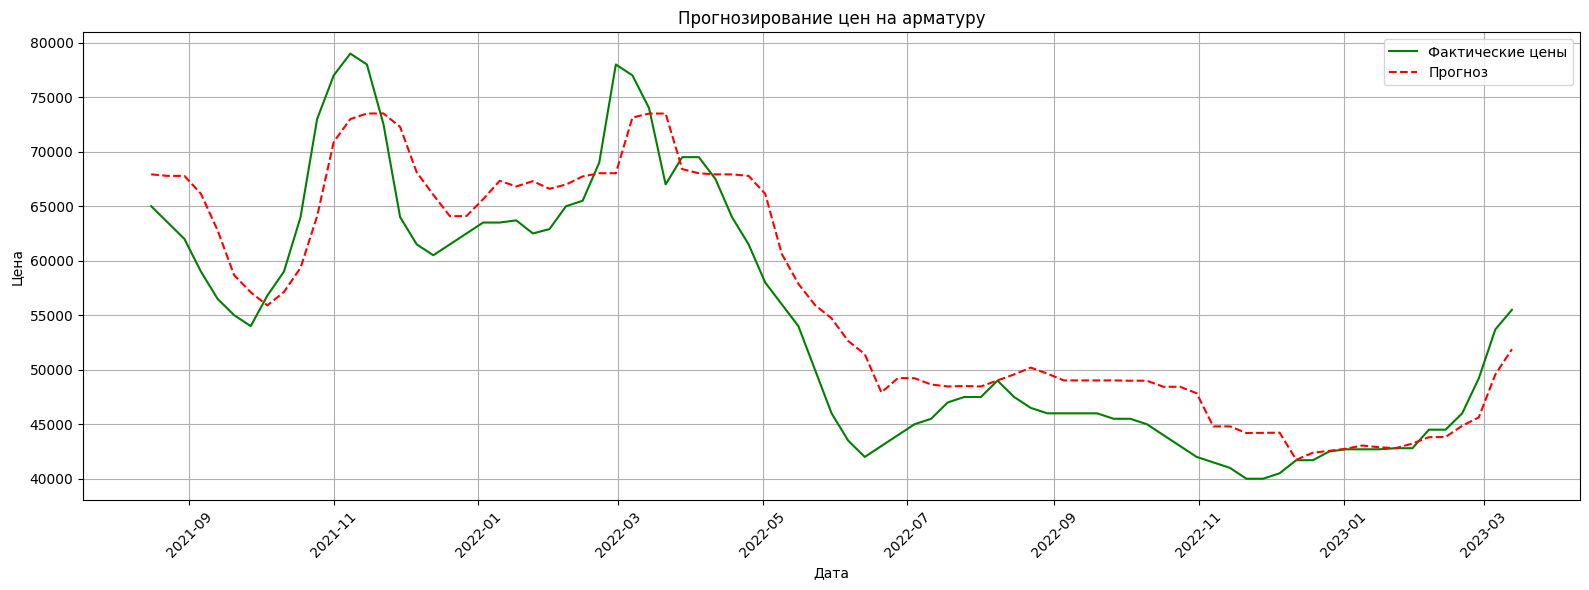

Оптимизированная модель сохранена!


In [1129]:
# Визуализация
plt.figure(figsize=(16, 6))
# plt.plot(train.index, train['Цена на арматуру'], label='Исторические данные', color='blue')
plt.plot(test.index, test['Price'], label='Фактические цены', color='green')
plt.plot(test.index, preds, label='Прогноз', color='red', linestyle='--')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Сохранение модели
joblib.dump(model, "catboost_model.pkl")
print("Оптимизированная модель сохранена!")

In [1130]:
print(combined_df.columns)

Index(['Price', 'year', 'month', 'week', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'rolling_mean_8', 'rolling_mean_16'],
      dtype='object')


#### Визуализация данных для обучения

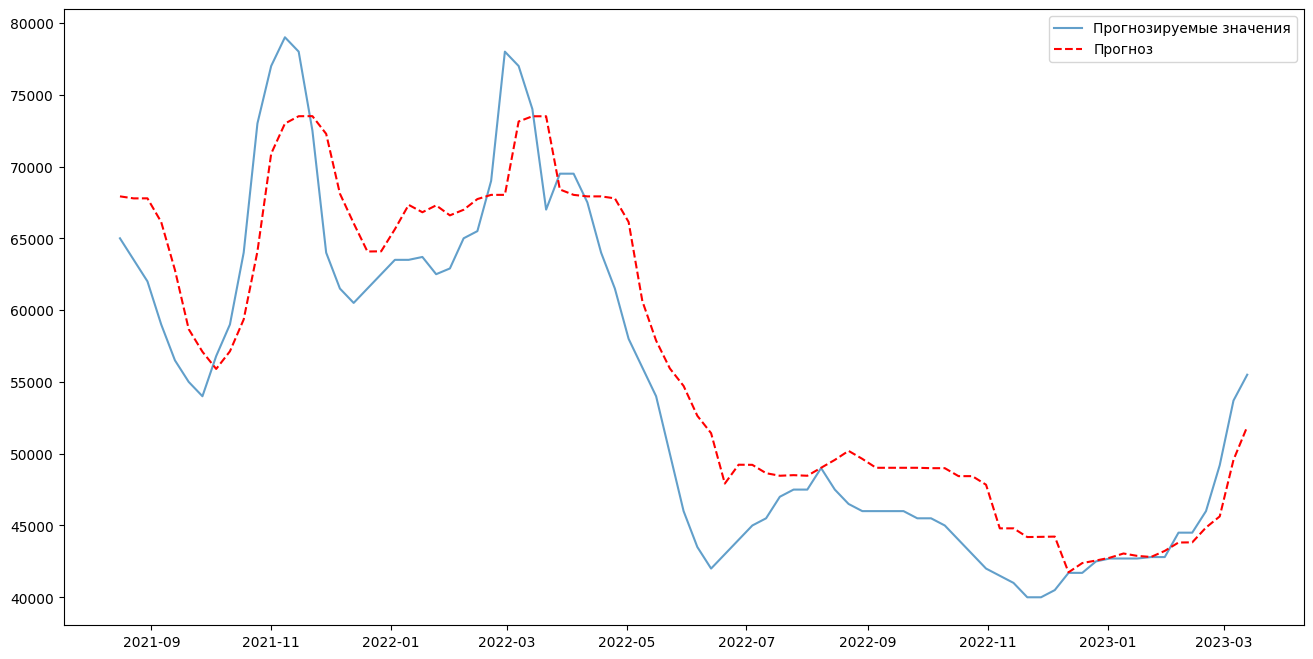

In [1131]:
plt.figure(figsize=(16, 8))
# plt.plot(y_train, label="Фактические значения", alpha=0.7)
plt.plot(y_test, label="Прогнозируемые значения", alpha=0.7)
plt.plot(test.index, preds, label='Прогноз', color='red', linestyle='--')
plt.legend()
plt.show()